In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

In [3]:
!pip install -q mlflow
!pip install -q python-dotenv

In [4]:
import os
project_folder = '/content/drive/MyDrive/nba-project'
os.chdir(project_folder)
pickles_folder = os.path.join(os.getcwd(), 'datasets')
os.getcwd()

'/content/drive/MyDrive/nba-project'

In [5]:
import custom_modules.modelling_lib_rodrixx as mod
import custom_modules.preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

import xgboost as xgb

from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor, RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv

from mlflow.server import get_app_client
import mlflow

In [6]:
env_path = os.path.join(os.getcwd(), 'env_files', '.env')
load_dotenv(env_path)
dataframes_path = os.path.join(os.getcwd(), 'datasets')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [7]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1982_to_2024.pkl'))

In [8]:
df.head()

,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,FG%,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,0.579,...,20,5,8,0.695,82,3,0.927,31,0.045,690
1,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,0.494,...,10,13,15,0.561,82,10,0.963,0,0.000,690
2,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,0.465,...,48,34,36,0.341,82,36,0.622,0,0.000,690
3,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,0.357,...,22,68,47,0.768,82,1,0.646,0,0.000,690
4,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,0.472,...,45,40,35,0.768,82,1,0.829,0,0.000,690


In [9]:
cols_tot_rank = [col for col in df.columns if '_tot' in col or '_rank' in col]
cols_to_drop = ['G', 'GS', 'GT', 'Votes', 'MaxVotes', 'Tm', 'FG_tot', '3PA_tot', '2PA_tot', 'FGA_rank_tot', 'Tm', 'Pos', 'Age', 'G', 'GS', 'FGA_pg', 'FG%', '3P_pg', '3PA_pg', '3P%', '2PA_pg', '2P%', 'eFG%', 'FT%', 'ORB_pg', 'DRB_pg', 'PF_pg', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'OBPM', 'DBPM']
cols_to_drop += cols_tot_rank
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']

In [10]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('AdjustColumns', prep.AdjustCols(cols_to_adjust = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [11]:
df = pipe_clean.fit_transform(df)

In [12]:
df.head()

,,MP_pg,FG_pg,2P_pg,FT_pg,FTA_pg,TRB_pg,AST_pg,STL_pg,BLK_pg,TOV_pg,...,USG%,OWS,DWS,WS,WS/48,BPM,VORP,%W,%G,Share
Player,Season,,,,,,,,,,,,,,,,,,,,,
Kareem Abdul-Jabbar,1982,35.2,9.9,9.9,4.1,5.8,8.7,3.0,0.8,2.7,3.0,...,0.256,6.9,3.9,10.7,0.192,5.0,4.7,0.695,0.927,0.045
Alvan Adams,1982,30.3,6.4,6.4,2.3,2.9,7.4,4.5,1.4,1.0,2.5,...,0.228,2.5,4.7,7.2,0.144,3.6,3.4,0.561,0.963,0.000
Mark Aguirre,1982,28.8,7.5,7.0,3.3,4.8,4.9,3.2,0.7,0.4,2.6,...,0.298,1.0,0.8,1.9,0.061,0.7,1.0,0.341,0.622,0.000
Danny Ainge,1982,10.6,1.5,1.4,1.1,1.2,1.1,1.6,0.7,0.1,1.0,...,0.215,-0.3,0.8,0.5,0.042,-2.7,-0.1,0.768,0.646,0.000
Tiny Archibald,1982,31.9,4.5,4.4,3.5,4.6,1.7,8.0,0.8,0.0,2.6,...,0.179,3.4,1.8,5.2,0.115,0.1,1.1,0.768,0.829,0.000


In [13]:
len(df[df.index.get_level_values(1) > 2017]) / len(df)

0.20560102029971303

In [14]:
val_df = df[df.index.get_level_values(1) > 2017]
dev_df = df[df.index.get_level_values(1) <= 2017]

In [15]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'ros', sampling_strategy = .4)

In [16]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [17]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [18]:
mlflow.set_experiment('Ensemble Random Forest & XGBoost v2')

2024/11/01 17:27:53 INFO mlflow.tracking.fluent: Experiment with name 'Ensemble Random Forest & XGBoost v2' does not exist. Creating a new experiment.


<Experiment: artifact_location='gs://nba-mvp-prediction-mlflow-artifacts/8', creation_time=1730482073859, experiment_id='8', last_update_time=1730482073859, lifecycle_stage='active', name='Ensemble Random Forest & XGBoost v2', tags={}>

In [19]:
params_1 = {
    'colsamples_bytree': .7,
    'learning_rate': .2,
    'max_depth': 3,
    'n_estimators': 150,
    'subsample': .7,
    'random_state': 23
}

params_2 = {
    'max_depth': 8,
    'max_features': .5,
    'min_samples_split': 10,
    'n_estimators': 220,
    'random_state': 23
}

In [20]:
with mlflow.start_run():
    estimator_1 = xgb.XGBRegressor(**params_1)
    estimator_2 = RandomForestRegressor(**params_2)

    model = VotingRegressor([('xgb', estimator_1), ('rf', estimator_2)], weights = [.7, .3], verbose = True)

    cv_scores = cross_validate(model, X_train, y_train, scoring = ('neg_root_mean_squared_error', 'r2'), cv = 10)

    model.fit(X_train, y_train)

    params = model.get_params()

    predicted_targets = mod.predict_model(model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_ens(params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val']))

[Voting] ...................... (1 of 2) Processing xgb, total=   2.9s
[Voting] ....................... (2 of 2) Processing rf, total=  17.8s
[Voting] ...................... (1 of 2) Processing xgb, total=   0.7s
[Voting] ....................... (2 of 2) Processing rf, total=  10.8s
[Voting] ...................... (1 of 2) Processing xgb, total=   0.8s
[Voting] ....................... (2 of 2) Processing rf, total=  11.5s
[Voting] ...................... (1 of 2) Processing xgb, total=   0.3s
[Voting] ....................... (2 of 2) Processing rf, total=  12.0s
[Voting] ...................... (1 of 2) Processing xgb, total=   0.3s
[Voting] ....................... (2 of 2) Processing rf, total=  11.9s
[Voting] ...................... (1 of 2) Processing xgb, total=   0.3s
[Voting] ....................... (2 of 2) Processing rf, total=  13.0s
[Voting] ...................... (1 of 2) Processing xgb, total=   0.3s
[Voting] ....................... (2 of 2) Processing rf, total=  11.4s
[Votin

2024/11/01 17:30:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/01 17:30:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run languid-hawk-988 at: https://nba-mvp-prediction.xyz/mlflow/#/experiments/8/runs/db41bc67feb2480198a5ae9780dc4fd7.
2024/11/01 17:30:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://nba-mvp-prediction.xyz/mlflow/#/experiments/8.


In [21]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.016984,0.019275,0.024208
R2,0.988375,0.965342,0.805624


In [22]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'])

In [23]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Share,PredShare
Player,Season,,
James Harden,2018,0.955,0.843596
LeBron James,2018,0.731,0.515689
Anthony Davis,2018,0.441,0.116578
Damian Lillard,2018,0.205,0.086637
Russell Westbrook,2018,0.075,0.252626
Giannis Antetokounmpo,2018,0.074,0.107922
Kevin Durant,2018,0.065,0.138834
DeMar DeRozan,2018,0.032,0.003533
LaMarcus Aldridge,2018,0.006,0.083408


,,Share,PredShare
Player,Season,,
Giannis Antetokounmpo,2019,0.932,0.641187
James Harden,2019,0.768,0.779756
Paul George,2019,0.352,0.118506
Nikola Jokić,2019,0.210,0.165050
Stephen Curry,2019,0.173,0.142671
Damian Lillard,2019,0.068,0.024966
Joel Embiid,2019,0.049,0.204802
Kevin Durant,2019,0.025,0.130941
Kawhi Leonard,2019,0.013,0.108418


,,Share,PredShare
Player,Season,,
Giannis Antetokounmpo,2020,0.952,0.593663
LeBron James,2020,0.746,0.292679
James Harden,2020,0.363,0.531304
Luka Dončić,2020,0.198,0.231886
Kawhi Leonard,2020,0.166,0.121360
Anthony Davis,2020,0.081,0.233989
Chris Paul,2020,0.026,-0.006308
Damian Lillard,2020,0.023,0.136237
Nikola Jokić,2020,0.018,0.049335


,,Share,PredShare
Player,Season,,
Nikola Jokić,2021,0.961,0.679035
Joel Embiid,2021,0.580,0.401386
Stephen Curry,2021,0.449,0.198105
Giannis Antetokounmpo,2021,0.345,0.202979
Chris Paul,2021,0.138,-0.004532
Luka Dončić,2021,0.042,0.253307
Damian Lillard,2021,0.038,0.188799
Julius Randle,2021,0.020,0.006121
Derrick Rose,2021,0.010,0.000138


,,Share,PredShare
Player,Season,,
Nikola Jokić,2022,0.875,0.537542
Joel Embiid,2022,0.706,0.550721
Giannis Antetokounmpo,2022,0.595,0.442735
Devin Booker,2022,0.216,0.104543
Luka Dončić,2022,0.146,0.292967
Jayson Tatum,2022,0.043,0.076470
Ja Morant,2022,0.010,0.193148
Stephen Curry,2022,0.004,0.018989
Chris Paul,2022,0.002,0.040688


,,Share,PredShare
Player,Season,,
Joel Embiid,2023,0.915,0.592323
Nikola Jokić,2023,0.674,0.560714
Giannis Antetokounmpo,2023,0.606,0.447879
Jayson Tatum,2023,0.280,0.294536
Shai Gilgeous-Alexander,2023,0.046,0.133131
Donovan Mitchell,2023,0.030,0.104828
Domantas Sabonis,2023,0.027,0.097854
Luka Dončić,2023,0.010,0.263690
Stephen Curry,2023,0.005,0.037855


,,Share,PredShare
Player,Season,,
Nikola Jokić,2024,0.935,0.878993
Shai Gilgeous-Alexander,2024,0.646,0.504262
Luka Dončić,2024,0.572,0.518101
Giannis Antetokounmpo,2024,0.194,0.349467
Jalen Brunson,2024,0.143,0.103600
Jayson Tatum,2024,0.087,0.165786
Anthony Edwards,2024,0.018,0.115102
Domantas Sabonis,2024,0.003,0.082391
Kevin Durant,2024,0.001,0.068542


No contenders results:


,,Share,PredShare
Player,Season,,
Álex Abrines,2018,0.0,0.000113
Quincy Acy,2018,0.0,0.000113
Steven Adams,2018,0.0,0.001389
Bam Adebayo,2018,0.0,0.000113
Arron Afflalo,2018,0.0,0.000113
...,...,...,...
Kaiser Gates,2024,0.0,0.000113
Danny Green,2024,0.0,0.000113
Ron Harper Jr.,2024,0.0,0.000113


In [24]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Share,PredShare
Player,Season,,
Trae Young,2022,0.0,0.178814
Damian Lillard,2023,0.0,0.151580
Joel Embiid,2024,0.0,0.402042
Anthony Davis,2024,0.0,0.128027


In [25]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'])

(<Figure size 4000x4000 with 8 Axes>, <Figure size 4000x4000 with 8 Axes>)

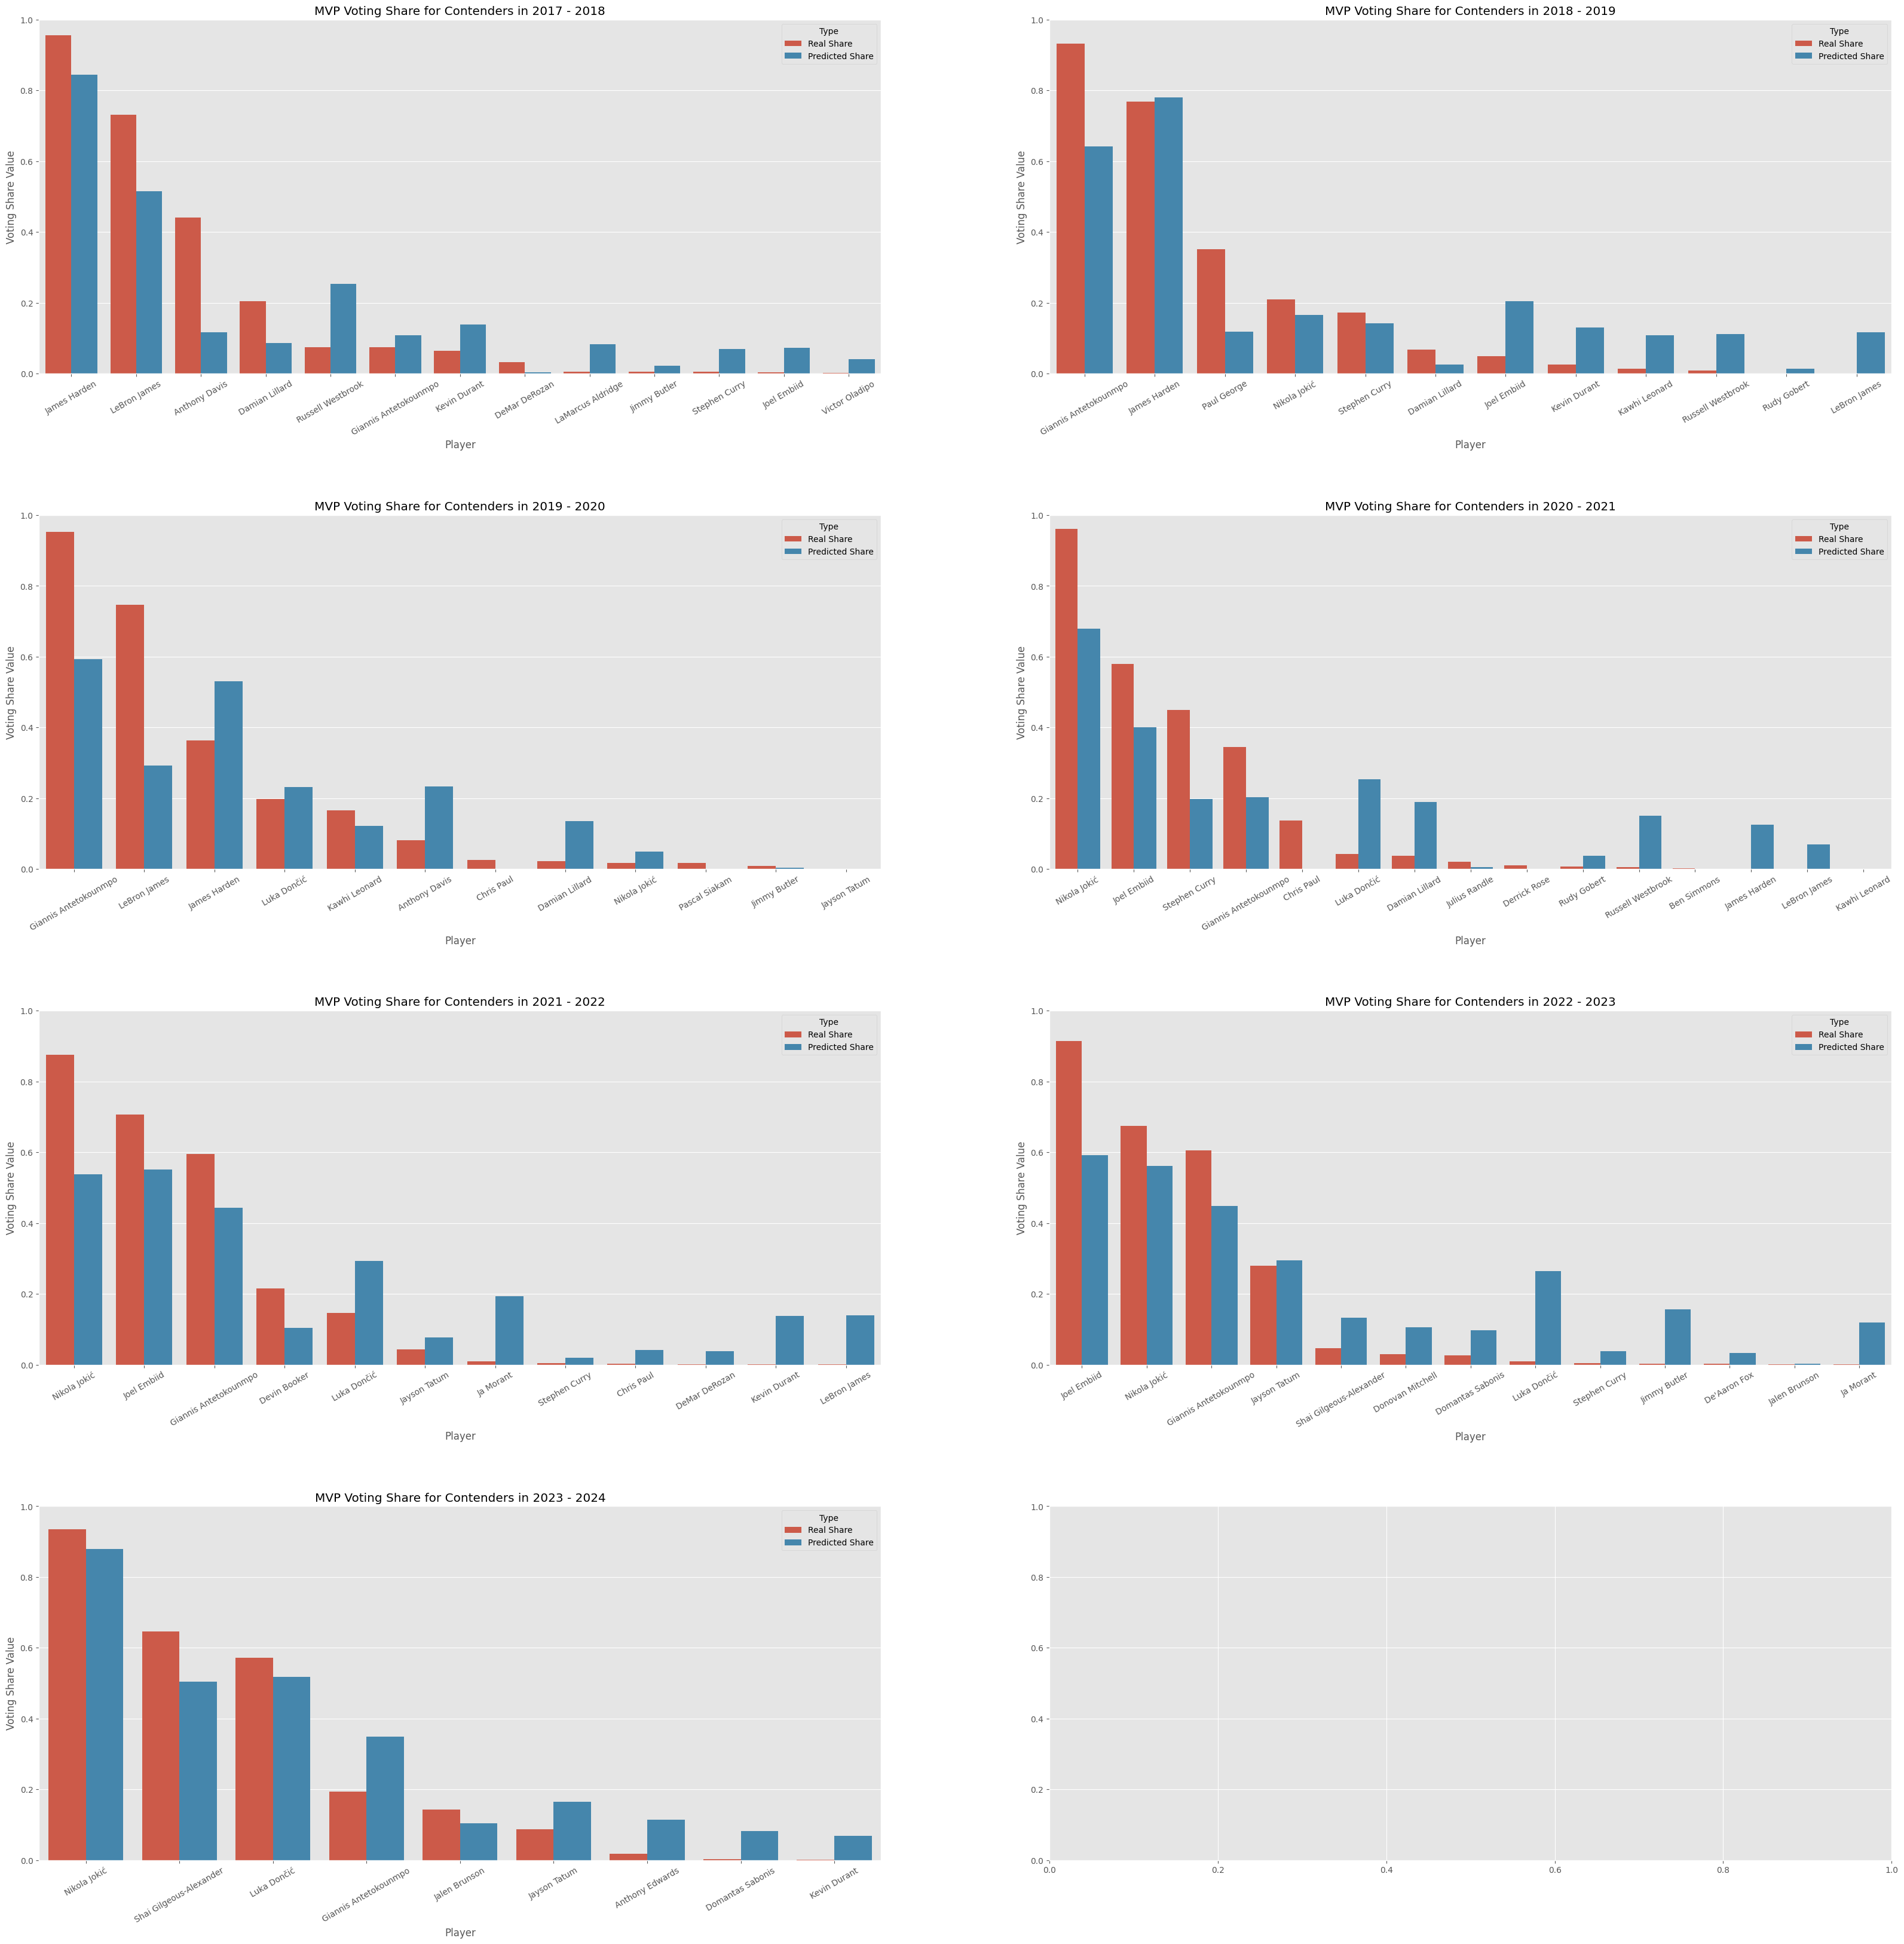

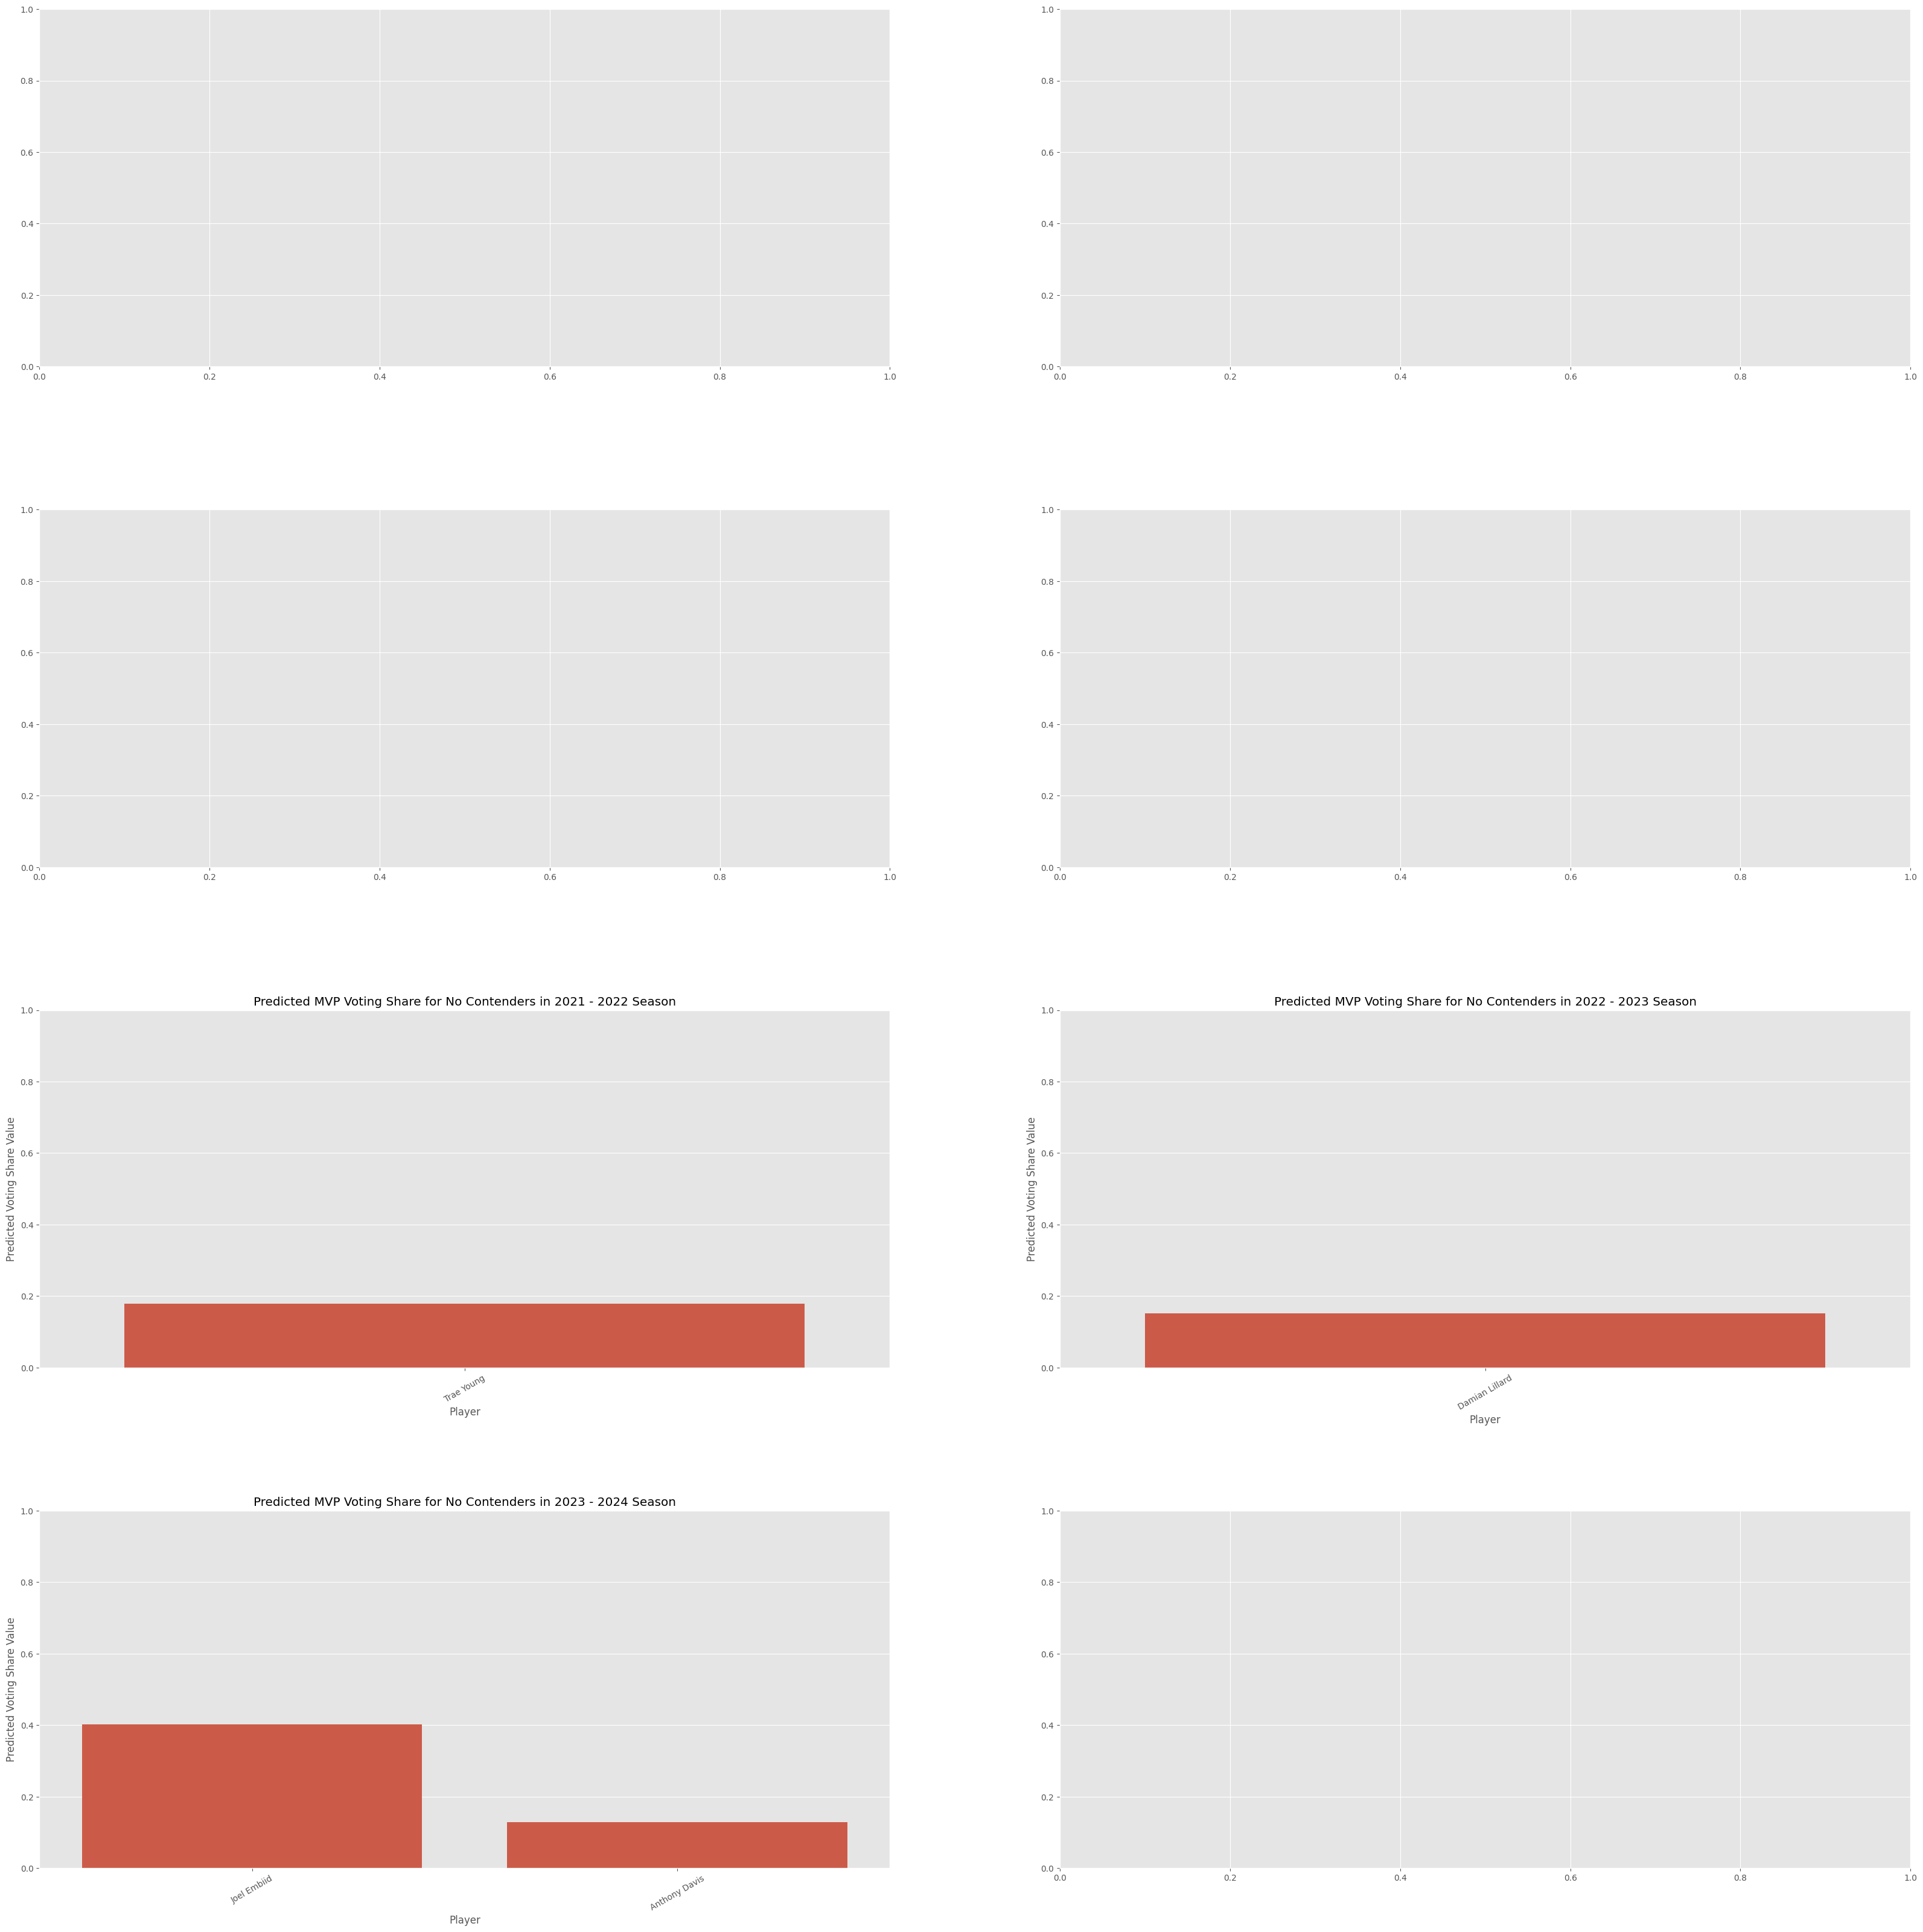

In [26]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'])